In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [2]:
dataset = pd.read_csv('SN_m_tot_V2.0.csv', delimiter=';', names=['Year', 'Month', 'Spaced Time','Sunspots','a','b','c'])

In [3]:
dataset.head()

,Year,Month,Spaced Time,Sunspots,a,b,c
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         3277 non-null   int64  
 1   Month        3277 non-null   int64  
 2   Spaced Time  3277 non-null   float64
 3   Sunspots     3277 non-null   float64
 4   a            3277 non-null   float64
 5   b            3277 non-null   int64  
 6   c            3277 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.3 KB


In [5]:
dataset.columns

Index(['Year', 'Month', 'Spaced Time', 'Sunspots', 'a', 'b', 'c'], dtype='object')

In [6]:
data = dataset.drop(['Year','Month','Spaced Time','a','b','c'],axis=1)
time = dataset.drop(['Year','Month','Sunspots','a','b','c'],axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3277 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


In [8]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Spaced Time  3277 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


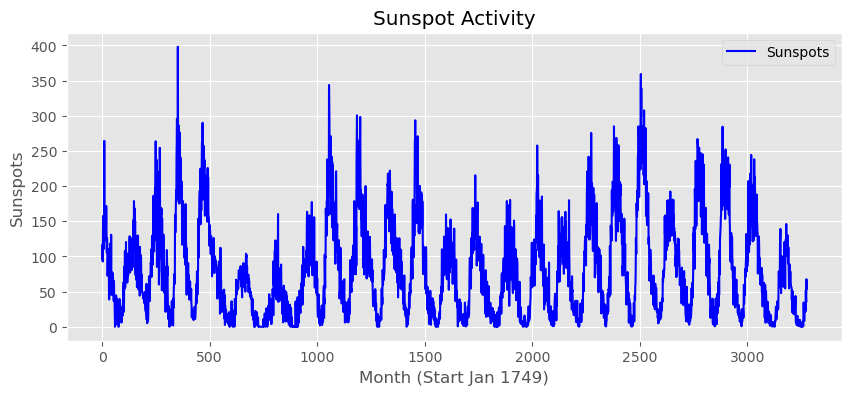

In [9]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

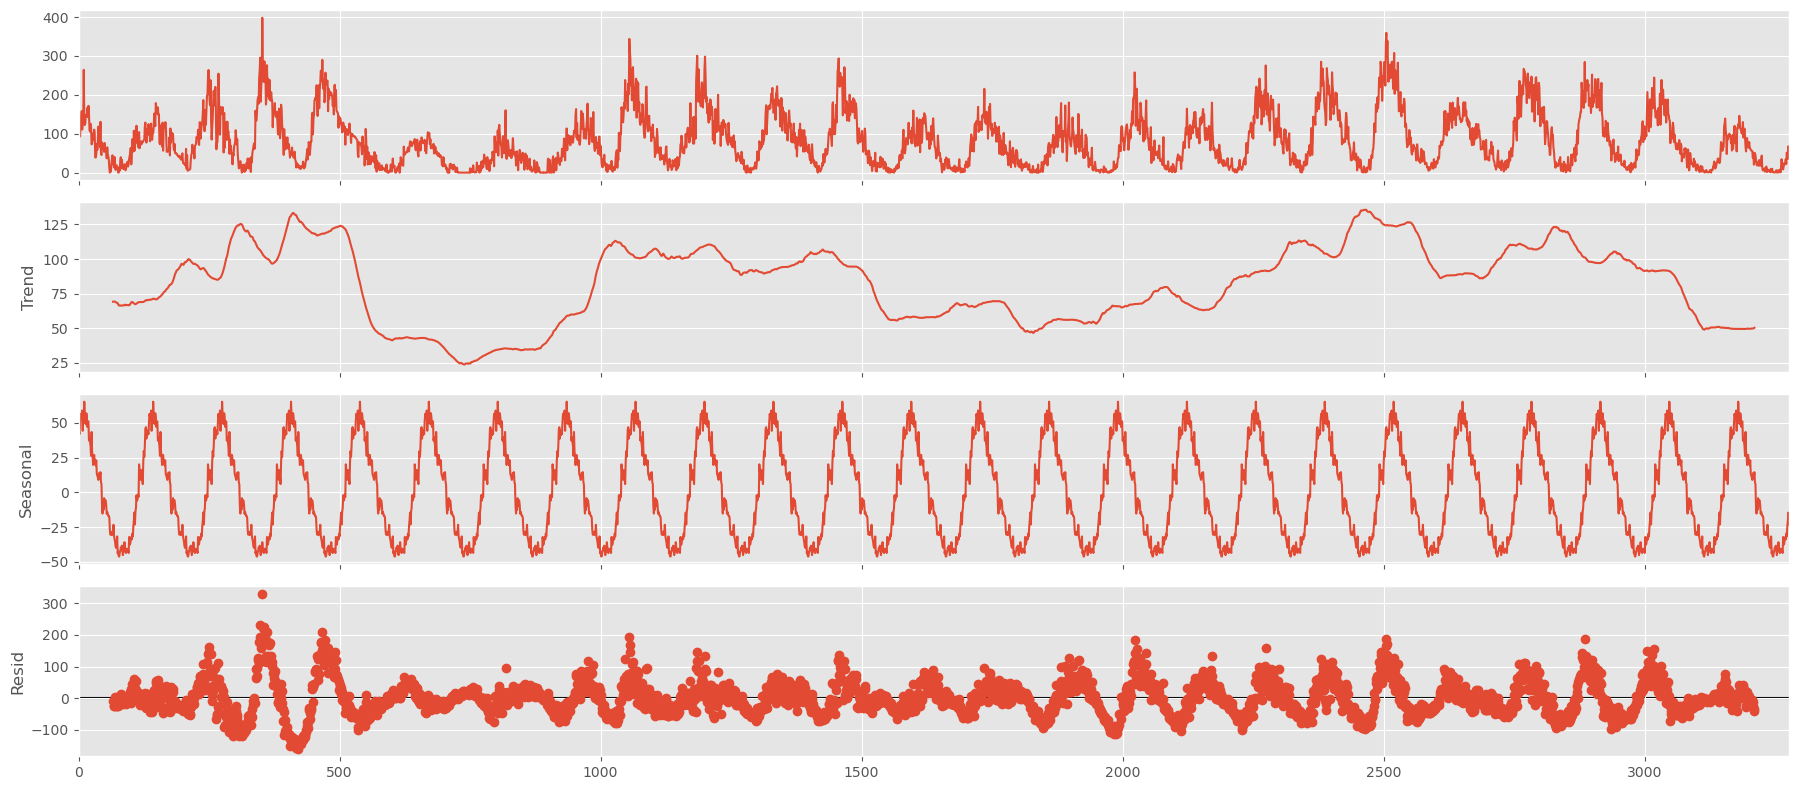

In [10]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 132)
fig = decomposition.plot()
plt.show()

In [11]:
data_raw = data.to_numpy()

In [12]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
scaler = QuantileTransformer(output_distribution='uniform')
# scaler = PowerTransformer()

data_scaled = scaler.fit_transform(data_raw)

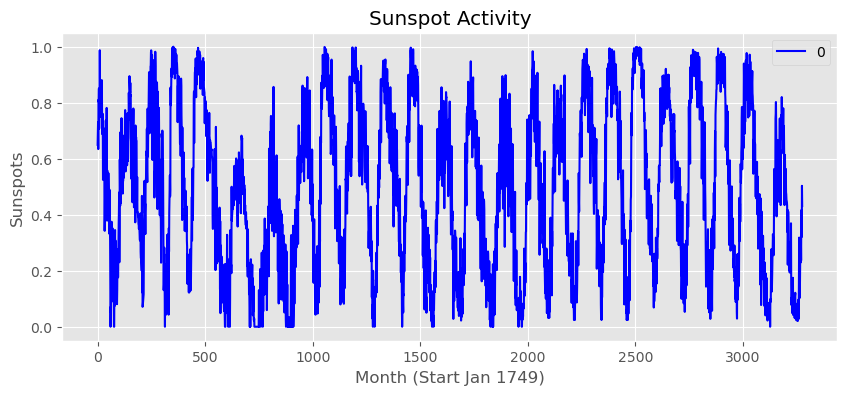

In [13]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

In [14]:
data_scaled.shape

(3277, 1)

In [15]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)
number_targets = len(data) - split
data_targets = data.to_numpy()[split:]

train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(2294, 1)
(983, 1)


In [16]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 100

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_3385/193180215.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_68u_j54pu8/croot/pytorch-select_1717607460029/work/torch/csrc/utils/tensor_new.cpp:277.)
  train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)


## Create the model and train it - Vanilla LSTM

In [17]:
print(train_x.shape)
print(train_y.shape)

torch.Size([1311, 983, 1])
torch.Size([1311, 1])


In [18]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [53]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])
print(df_predict)

      Prediction
2294  104.309094
2295  107.162794
2296  108.471112
2297  109.411529
2298  110.515159
...          ...
3272  158.198758
3273  158.198758
3274  158.198758
3275  158.198758
3276  158.198758

[983 rows x 1 columns]


In [20]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [21]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 2
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [25/100], Loss: 0.0027
Epoch [50/100], Loss: 0.0005
Epoch [75/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0001
Epoch [25/100], Loss: 0.0028
Epoch [50/100], Loss: 0.0007
Epoch [75/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0007


In [22]:
print(final_vanilla.shape)
print(final_vanilla)

(983,)
[102.80975966 104.09366789 105.17382535 101.82344579  97.94287826
  91.77178097  93.80036887  89.16083889  88.19874799  85.06336269
  83.67296467  85.70731789  84.27769498  81.37499818  80.13844467
  78.40771404  79.99556752  76.41655906  75.51415458  72.72881805
  74.61453281  75.33269368  73.67173084  72.79683575  71.8092831
  72.06100371  71.65766722  70.37870011  70.61819846  69.11822694
  70.42498016  68.61460222  69.87201048  67.76311388  68.00144304
  69.19608287  66.24263286  68.48518763  68.70058903  69.44643671
  69.94209322  71.71273391  70.61354645  73.68682283  67.89657307
  72.54238491  69.9331787   70.05316807  69.12361128  71.90895515
  67.39742324  70.86650332  69.96151713  70.06840509  70.69549175
  70.71674342  71.57596987  70.36526013  73.4837493   70.14444758
  73.90076529  77.35768107  75.40799303  73.37007349  69.28681849
  70.95153747  74.13438068  76.00905599  81.23826574  77.57292156
  71.69043873  70.55438196  69.1374502   72.47018     67.75722043
  68

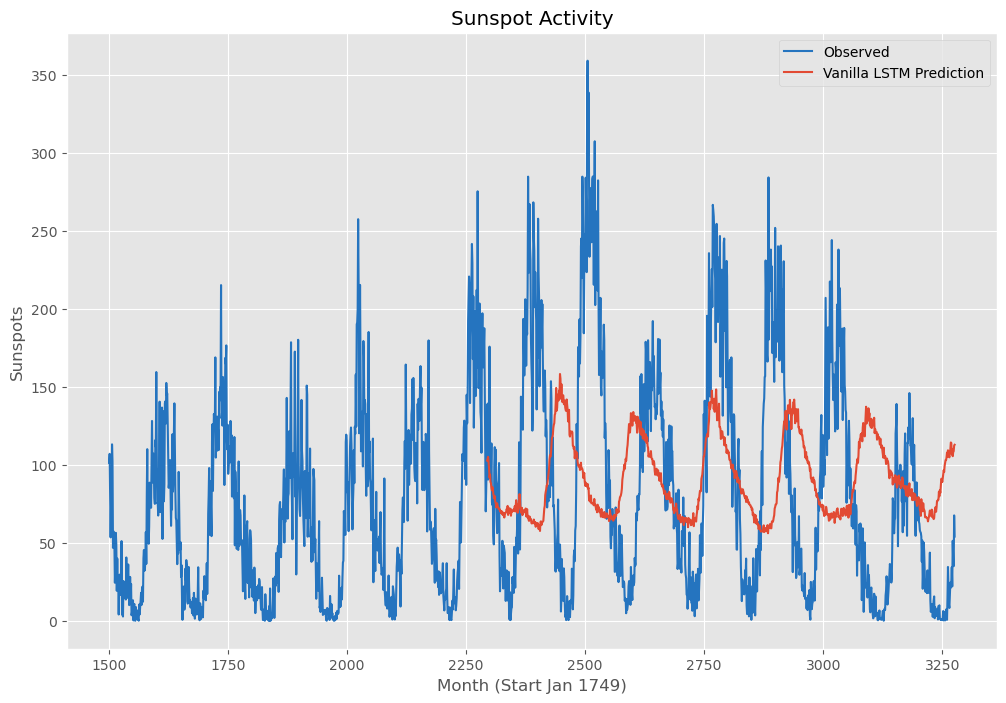

In [23]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [24]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [25]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 6280.83, 'RMSE': 79.25, 'MAPE': 9947.81}

## Stacked LSTM


In [26]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
# Train and predict multiple times
n_runs = 2
epochs = 100
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0003
Epoch [75/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0052
Epoch [25/100], Loss: 0.0031
Epoch [50/100], Loss: 0.0019
Epoch [75/100], Loss: 0.0020
Epoch [100/100], Loss: 0.0000
[103.17973558 108.16751754 101.67279832  98.71526651  94.79576075
  89.29108433  85.1866875   80.78997179  79.58342733  77.93123181
  75.99614946  74.05156652  71.44881807  69.72492173  67.69615355
  64.18672985  61.50256594  58.8884653   57.76911185  55.36701655
  52.76535172  49.84345008  48.43446265  44.61550697  42.9790691
  42.23757322  41.18908948  38.22269145  36.64630122  33.47099748
  35.03433874  31.73555324  30.55041979  29.45720612  28.99066873
  27.77325608  25.15708697  25.19242005  23.92569872  22.820077
  22.22205552  21.91326716  19.4084705   20.23017174  14.891464
  14.08064901  14.08933597  13.06427211  11.96746235  12.01596542
  10.3         11.04365666  10.34798597  10.2         10.25937181
  10.18432092  10.46749503  10.28696394  11.7

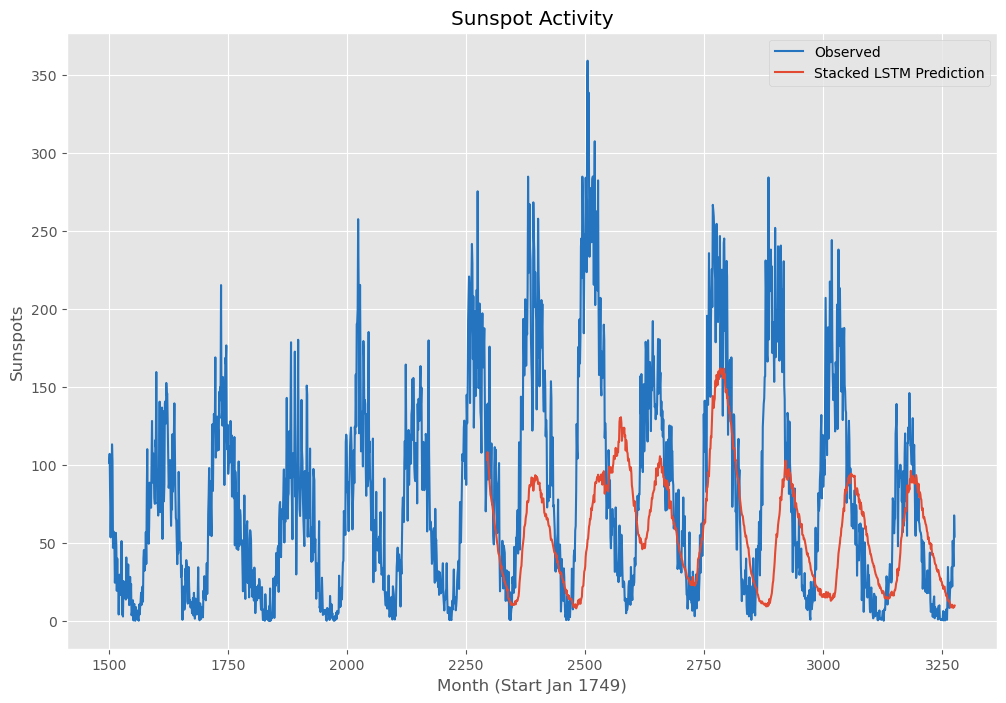

In [28]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [29]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 8097.84, 'RMSE': 89.99, 'MAPE': 6424.02}